# Modelling Project

***MEIN40330 - AI for Personalised Medicine - 2024/25 Summer***

> - **Name:** Yu Du
> - **Date:** July 5, 2025

**Keywords:** **OV**, **ODE**, **p53**, **Kaplan Meier**, **DNA Damaging**

In this modeling project assignment, I selected ovarian cancer (OV) as my research focus. To better address Question 1, I accessed the [*SANTA CRUZ*](https://xenabrowser.net/datapages/?cohort=TCGA%20Ovarian%20Cancer%20(OV)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443) platform, which appears to be a mirror site of TCGA maintained by the University of California, and downloaded the necessary datasets from there. The following two primary datasets were used for Question 1:

- **Gene expression RNAseq - IlluminaHiSeq UNC** -- HiSeqV2.tsv
- **Phenotype - Curated survival data** -- OV_survival.txt

As suggested in the hint for Question 2, I separately downloaded datasets from [*DepMap*](https://depmap.org/portal/data_page/?tab=allData) and [*Genomics of Drug Sensitivity in Cancer*](https://www.cancerrxgene.org/downloads/bulk_download). The datasets used for Question 2 are as follows:

- **Log(TPM+1) mRNA expression matrix for cell lines** -- OmicsExpressionProteinCodingGenesTPMLogp1.csv
- **DepMap Cell Line Information** -- Model.csv
- **Drug response data (IC50/AUC)** -- GDSC2_fitted_dose_response_27Oct23.xlsx
- **Drug mechanism / classification information** -- screened_compounds_rel_8.5.csv
- **GDSC cell line information** -- Cell_Lines_Details.xlsx

Additionally, I have stored the raw datasets, intermediate files, and final results on [my Google Drive](https://drive.google.com/drive/folders/16yMGbp44xWxN7rayYas7FQS0cQTnCjzD?usp=sharing) for reference.

The required runtime environment can be set up using the following commands:
```bash
conda create -n afpm-lab-env python=3.10 -y
conda activate afpm-lab-env
pip install numpy pandas scipy matplotlib lifelines openpyxl
```

**Outline**
- [Can the p53 model predict patient survival (use TCGA data)?](#can-the-p53-model-predict-patient-survival-use-tcga-data)
- [Can the p53 model predict the responses to DNA damaging drugs in cell lines (use CCLE & GDSC data)?](#can-the-p53-model-predict-the-responses-to-dna-damaging-drugs-in-cell-lines-use-ccle--gdsc-data)
- [Reference](#reference)

In [ ]:
# Import necessary packages
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import spearmanr, pearsonr

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test

***

## Can the p53 model predict patient survival (use TCGA data)?

In [2]:
# ---------- Read expression data and convert into matched format----------
# Define the gene expression data file path
expression_file = "./HiSeqV2.tsv"

# Avoid situations where the file does not exist
try:
    expr_df = pd.read_csv(expression_file, sep='\t', index_col=0)
except FileNotFoundError:
    print("Error: File does not exist!")

# Transpose (rows become samples, columns become genes)
df_transposed = expr_df.T

# Save in a format that matches the p53 model's expectations
df_transposed.to_csv("./nb_params_full_1.csv")

Since the dataset I obtained was `HiSeqV2.tsv`, which had the opposite orientation compared to what the model file `p53_model_updated.ipynb` expected (as provided on Brightspace), I transposed the data to make it compatible. After converting the data, I fed it into the model file and obtained two intermediate datasets, each corresponding to a different phosphorylation site:

- p53s15DR_tp53_1.csv
- p53s46DR_tp53_1.csv

Best predictor: DDR_0.010 (p = 4.8905e-02, HR = 576772.401)
Optimal threshold for DDR_0.010: 0.1241, p = 9.1335e-03


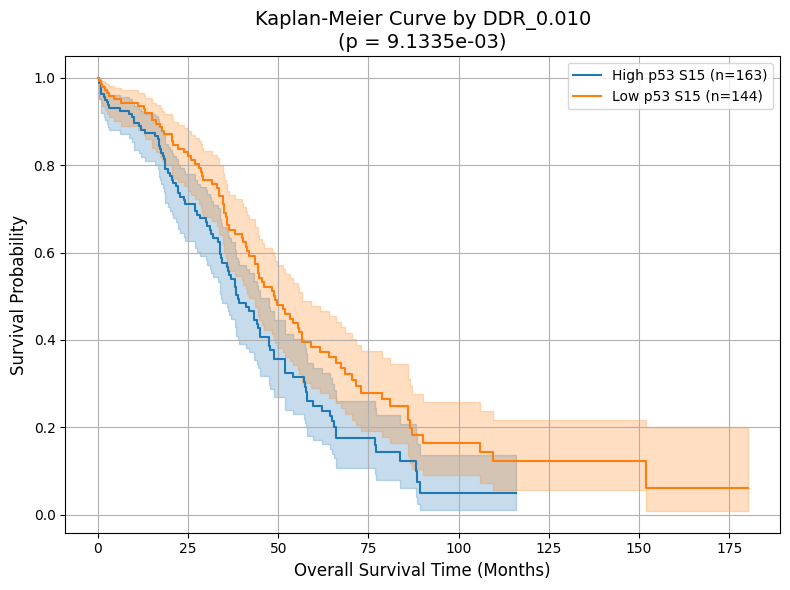

In [ ]:
# ---------- Prepare data ----------
# Read data
survival_file = "./OV_survival.txt"
p53s15dr_file = "./p53s15DR_tp53_1.csv"
p53s46dr_file = "./p53s46DR_tp53_1.csv"

survival_df = pd.read_csv(survival_file, sep='\t', index_col=0)
p53s15dr_df = pd.read_csv(p53s15dr_file)
p53s46dr_df = pd.read_csv(p53s46dr_file)

# Clean and transform survival data
survival_df = survival_df[['OS', 'OS.time']].copy()
survival_df.rename(columns={'OS': 'event', 'OS.time': 'time'}, inplace=True)
survival_df = survival_df.dropna()

# Merge data
merged_s15 = pd.merge(p53s15dr_df, survival_df, left_on="SAMPLE_ID", right_index=True)
merged_s15 = merged_s15.dropna()
merged_s46 = pd.merge(p53s46dr_df, survival_df, left_on="SAMPLE_ID", right_index=True)
merged_s46 = merged_s46.dropna()

merged_s15['event'] = merged_s15['event'].astype(int)
merged_s15['time'] = merged_s15['time'].astype(float) / 30.44
merged_s46['event'] = merged_s46['event'].astype(int)
merged_s46['time'] = merged_s46['time'].astype(float) / 30.44

# ---------- p53s15DR ----------
# Traverse the DDR simulation column to do Cox regression and record the p value
ddr_cols_s15 = [col for col in merged_s15.columns if col.startswith("DDR_")]
pvals_s15 = []
hazards_s15 = []

for col in ddr_cols_s15:
    df_tmp = merged_s15[[col, 'time', 'event']].copy()
    df_tmp = df_tmp.rename(columns={col: 'feature'})
    cph = CoxPHFitter()
    cph.fit(df_tmp, duration_col='time', event_col='event')
    summary = cph.summary
    pval = summary.loc['feature', 'p']
    hz = summary.loc['feature', 'exp(coef)']
    pvals_s15.append((col, pval, hz))

# Find the optimal column (with the smallest p-value)
pvals_s15_sorted = sorted(pvals_s15, key=lambda x: x[1])
opt_col_s15, opt_pval_s15, opt_hz_s15 = pvals_s15_sorted[0]
print(f"Best predictor: {opt_col_s15} (p = {opt_pval_s15:.4e}, HR = {opt_hz_s15:.3f})")

# Find the optimal threshold for Kaplan-Meier analysis
pathway_data_s15 = merged_s15[opt_col_s15].values
clinical_time_s15 = merged_s15['time'].values
clinical_event_s15 = merged_s15['event'].values

# Build threshold filter
unique_values_s15 = np.sort(np.unique(pathway_data_s15))
pval_list_s15 = []

for i in range(1, len(unique_values_s15) - 1):
    threshold = unique_values_s15[i]
    group = pathway_data_s15 > threshold
    result = logrank_test(clinical_time_s15[group], clinical_time_s15[~group],
                          clinical_event_s15[group], clinical_event_s15[~group])
    pval_list_s15.append((threshold, result.p_value))

# Find the optimal threshold
best_threshold_s15, best_p_s15 = min(pval_list_s15, key=lambda x: x[1])
print(f"Optimal threshold for {opt_col_s15}: {best_threshold_s15:.4f}, p = {best_p_s15:.4e}")

# Plot Kaplan-Meier curve
group = pathway_data_s15 > best_threshold_s15
kmf_s15 = KaplanMeierFitter()

plt.figure(figsize=(8,6))
for label, grp in zip(["High p53 S15", "Low p53 S15"], [True, False]):
    ix = group == grp
    kmf_s15.fit(clinical_time_s15[ix], clinical_event_s15[ix], label=f"{label} (n={ix.sum()})")
    kmf_s15.plot(ci_show=True)

plt.title(f"Kaplan-Meier Curve by {opt_col_s15}\n(p = {best_p_s15:.4e})", fontsize=14)
plt.xlabel("Overall Survival Time (Months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

I then merged these intermediate datasets with the clinical survival data (OV_survival.txt) based on sample IDs. Using this combined dataset, I performed Cox regression analysis with survival time and survival status, recorded the p-values, and identified the optimal thresholds for stratification to plot Kaplan–Meier curves.

As for the results: based on simulations using the p53 model with DDR stimulation and transcriptomic input from TCGA-OV patients, we predicted the phosphorylation levels of p53 at serine 15. When stratifying patients by the predicted p53 S15 activity levels and performing Kaplan–Meier survival analysis, we observed a statistically significant difference between the high and low activity groups (p = 0.0091).

/opt/miniconda3/envs/afpm-lab-env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['feature'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Best predictor: DDR_0.120 (p = 2.4177e-01, HR = 0.968)
Optimal threshold for DDR_0.120: 13.2576, p = 1.9793e-02


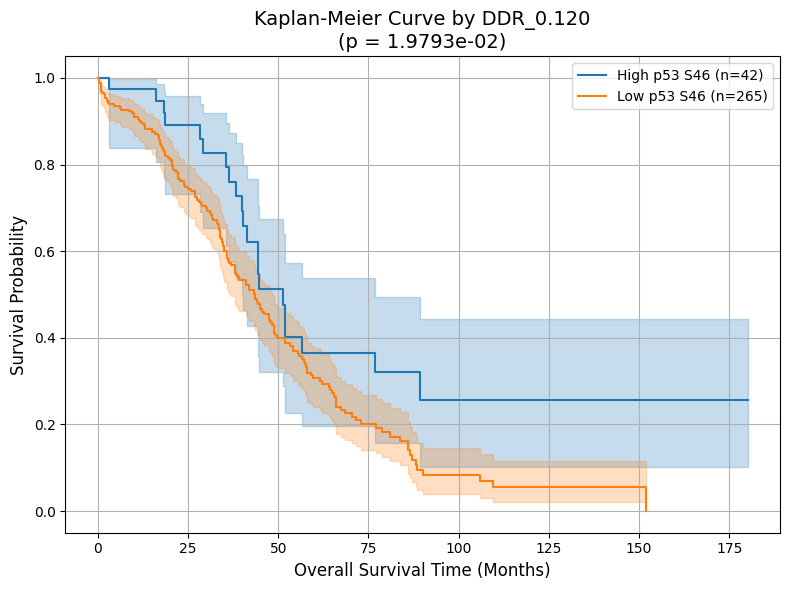

In [4]:
# ---------- p53s46DR ----------
# Traverse the DDR simulation column to do Cox regression and record the p value
ddr_cols_s46 = [col for col in merged_s46.columns if col.startswith("DDR_")]
pvals_s46 = []
hazards_s46 = []

for col in ddr_cols_s46:
    df_tmp = merged_s46[[col, 'time', 'event']].copy()
    df_tmp = df_tmp.rename(columns={col: 'feature'})
    cph = CoxPHFitter()
    cph.fit(df_tmp, duration_col='time', event_col='event')
    summary = cph.summary
    pval = summary.loc['feature', 'p']
    hz = summary.loc['feature', 'exp(coef)']
    pvals_s46.append((col, pval, hz))

# Find the optimal column (with the smallest p-value)
pvals_s46_sorted = sorted(pvals_s46, key=lambda x: x[1])
opt_col_s46, opt_pval_s46, opt_hz_s46 = pvals_s46_sorted[0]
print(f"Best predictor: {opt_col_s46} (p = {opt_pval_s46:.4e}, HR = {opt_hz_s46:.3f})")

# Find the optimal threshold for Kaplan-Meier analysis
pathway_data_s46 = merged_s46[opt_col_s46].values
clinical_time_s46 = merged_s46['time'].values
clinical_event_s46 = merged_s46['event'].values

# Build threshold filter
unique_values_s46 = np.sort(np.unique(pathway_data_s46))
pval_list_s46 = []

for i in range(1, len(unique_values_s46) - 1):
    threshold = unique_values_s46[i]
    group = pathway_data_s46 > threshold
    result = logrank_test(clinical_time_s46[group], clinical_time_s46[~group],
                          clinical_event_s46[group], clinical_event_s46[~group])
    pval_list_s46.append((threshold, result.p_value))

# Find the optimal threshold
best_threshold_s46, best_p_s46 = min(pval_list_s46, key=lambda x: x[1])
print(f"Optimal threshold for {opt_col_s46}: {best_threshold_s46:.4f}, p = {best_p_s46:.4e}")

# Plot Kaplan-Meier curve
group = pathway_data_s46 > best_threshold_s46
kmf_s46 = KaplanMeierFitter()

plt.figure(figsize=(8,6))
for label, grp in zip(["High p53 S46", "Low p53 S46"], [True, False]):
    ix = group == grp
    kmf_s46.fit(clinical_time_s46[ix], clinical_event_s46[ix], label=f"{label} (n={ix.sum()})")
    kmf_s46.plot(ci_show=True)

plt.title(f"Kaplan-Meier Curve by {opt_col_s46}\n(p = {best_p_s46:.4e})", fontsize=14)
plt.xlabel("Overall Survival Time (Months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

The result is similar to that of the previous p53 S15 analysis, also showing a statistically significant difference in survival (p-value = 0.0198). However, unlike the S15 result — where the high p53 S15 group showed worse survival — the high p53 S46 group demonstrates better survival outcomes.

Overall, the p53 kinetic model is capable of predicting patient survival using TCGA data by modeling post-translational modifications (S15/S46) under DDR stimulation. Both phosphorylation sites show statistically significant associations with survival outcomes, confirming the model’s biological relevance and predictive utility.


## Can the p53 model predict the responses to DNA damaging drugs in cell lines (use CCLE & GDSC data)?

In [5]:
# ---------- Read expression data and convert into matched format ----------
# Read data
protein_expr_file = "./OmicsExpressionProteinCodingGenesTPMLogp1.csv"
protein_expr_df = pd.read_csv(protein_expr_file, index_col=0)

# List of genes required to define the p53 model
required_genes = ['ATM', 'CHEK2', 'HIPK2', 'MDM2', 'PPM1D', 'SIAH1', 'TP53', 'WSB1']

# Match the target column from the column name (column name is in "Gene Name (EntrezID)" format)
selected_columns = [col for col in protein_expr_df.columns if any(col.startswith(gene + ' ') for gene in required_genes)]
protein_expr_df_subset = protein_expr_df[selected_columns].copy()

# Remove (EntrezID) from the column name, leaving only the gene symbol
protein_expr_df_subset.columns = [re.sub(r"\s*\(.*?\)", "", col) for col in protein_expr_df_subset.columns]

# Keep index (cell line ID)
protein_expr_df_subset.index.name = 'CellLine_ID'

# Save in a format that matches the p53 model's expectations
protein_expr_df_subset.to_csv("./nb_params_full_2.csv")

Next, I selected the target genes from the raw dataset and performed some preprocessing. As in Question 1, I then fed the data into the model file `p53_model_updated.ipynb` and obtained two intermediate datasets:

- p53s15DR_tp53_2.csv
- p53s46DR_tp53_2.csv

In [6]:
# ---------- Prepare data ----------
# Read data
p53s15dr_file = "./p53s15DR_tp53_2_new.csv"
p53s46dr_file = "./p53s46DR_tp53_2_new.csv"
gdsc_response_file = "./GDSC2_fitted_dose_response_27Oct23.xlsx"
ccle_model_file = "./Model.csv"
compound_info_file = "./screened_compounds_rel_8.5.csv"
cell_line_info_file = "./Cell_Lines_Details.xlsx"

p53s15dr_df = pd.read_csv(p53s15dr_file)
p53s46dr_df = pd.read_csv(p53s46dr_file)
gdsc_response_df = pd.read_excel(gdsc_response_file)
ccle_model_df = pd.read_csv(ccle_model_file)
compound_df = pd.read_csv(compound_info_file)
cell_line_df = pd.read_excel(cell_line_info_file)

# Set CellLine_ID to index
p53s15dr_df = p53s15dr_df.set_index("CellLine_ID")
p53s46dr_df = p53s46dr_df.set_index("CellLine_ID")

# Filter the CCLE model table for rows with COSMIC ID
ccle_model_df = ccle_model_df[['ModelID', 'StrippedCellLineName', 'COSMICID']]
ccle_model_df = ccle_model_df.dropna()
ccle_model_df['COSMICID'] = ccle_model_df['COSMICID'].astype(int)

# ---------- p53s15DR ----------
# Add COSMIC ID to ODE simulation results (matched by CellLineName)
# p53s15dr_df = p53s15dr_df.reset_index()
merged_ode_s15 = pd.merge(p53s15dr_df, ccle_model_df, left_index=True, right_on='ModelID', how='inner')

# Screen all DNA-damaging drugs
dna_related = compound_df[compound_df['TARGET_PATHWAY'].str.contains("DNA", case=False, na=False)]
dna_drugs = dna_related['DRUG_NAME'].unique().tolist()

# Screen IC50 values ​​of DNA-damaging drugs by GDSC
gdsc_sub_s15 = gdsc_response_df[
    (gdsc_response_df['DRUG_NAME'].isin(dna_drugs)) &
    (gdsc_response_df['COSMIC_ID'].isin(merged_ode_s15['COSMICID']))
]

# Combine GDSC drug responses with ODE model results
combined_df_s15 = pd.merge(
    gdsc_sub_s15,
    merged_ode_s15,
    left_on='COSMIC_ID',
    right_on='COSMICID',
    how='inner'
)

# Analyze correlation (p53 DDR_0.450 vs LN_IC50)
results_s15 = []
for drug in combined_df_s15['DRUG_NAME'].unique():
    subset = combined_df_s15[combined_df_s15['DRUG_NAME'] == drug]
    if len(subset) < 5:
        continue
    x = subset['DDR_0.450']
    y = subset['LN_IC50']
    pearson_corr, pearson_p = pearsonr(x, y)
    spearman_corr, spearman_p = spearmanr(x, y)
    results_s15.append({
        "Drug": drug,
        "N": len(subset),
        "Pearson_r": pearson_corr,
        "Pearson_p": pearson_p,
        "Spearman_r": spearman_corr,
        "Spearman_p": spearman_p
    })

# Save and print the results
results_s15_df = pd.DataFrame(results_s15).sort_values("Spearman_r", ascending=True)
results_s15_df.to_csv("./drug_response_correlation_p53s15.csv", index=False)
print("Correlation analysis of p53s15 in predicting response to DNA damaging drugs:")
print(results_s15_df.head())

Correlation analysis of p53s15 in predicting response to DNA damaging drugs:
                Drug     N  Pearson_r     Pearson_p  Spearman_r    Spearman_p
9         Epirubicin   689  -0.230144  9.822871e-10   -0.172700  5.134102e-06
11       Leflunomide   647  -0.243177  3.660666e-10   -0.161044  3.866289e-05
4        Oxaliplatin  1235  -0.213382  3.491791e-14   -0.156507  3.227982e-08
10  Cyclophosphamide   689  -0.196270  2.068327e-07   -0.156027  3.900316e-05
5        Gemcitabine   693  -0.172777  4.771658e-06   -0.142672  1.643396e-04


/opt/miniconda3/envs/afpm-lab-env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In this section, I identified some classic DNA-damaging drugs—such as platinum compounds (e.g., Oxaliplatin) and anthracyclines (e.g., Epirubicin) — by correlating the processed datasets. The results suggest that the p53 model can predict cell line responses to DNA-damaging agents to some extent. However, the predictive power is weak overall, with Spearman correlation coefficients ranging from -0.07 to -0.17.

Several points are worth mentioning. First, regarding the mechanism used to select DNA-damaging drugs: I simply filtered for drugs with target pathways containing the word “DNA.” This approach may have excluded other DNA-damaging agents whose pathways are labeled under terms such as “cell cycle” or “chromatin organization.” Therefore, although it is rather coarse and may lead to false negatives or misclassifications, this selection method is simple and convenient for hypothesis validation.

Second, in the correlation analysis, I focused on two key indicators: p53_DDR_0.450 and LN_IC50. The log-transformed IC50 is a well-established metric of drug sensitivity, while p53_DDR_0.450 represents the model’s predicted p53 activity in a relatively stable phase. Using this intermediate time point helps reduce the influence of early fluctuations or saturation effects that might interfere with downstream analysis.

Finally, I saved the complete correlation results for both p53 S15 and S46 (in next stage) into the files `drug_response_correlation_p53s15.csv` and `drug_response_correlation_p53s46.csv` for future reference.

In [7]:
# ---------- p53s15DR ----------
# Add COSMIC ID to ODE simulation results (matched by CellLineName)
# p53s46dr_df = p53s46dr_df.reset_index()
merged_ode_s46 = pd.merge(p53s46dr_df, ccle_model_df, left_index=True, right_on='ModelID', how='inner')

# Screen IC50 values ​​of DNA-damaging drugs by GDSC
gdsc_sub_s46 = gdsc_response_df[
    (gdsc_response_df['DRUG_NAME'].isin(dna_drugs)) &
    (gdsc_response_df['COSMIC_ID'].isin(merged_ode_s46['COSMICID']))
]

# Combine GDSC drug responses with ODE model results
combined_df_s46 = pd.merge(
    gdsc_sub_s46,
    merged_ode_s46,
    left_on='COSMIC_ID',
    right_on='COSMICID',
    how='inner'
)

# Analyze correlation (p53 DDR_0.450 vs LN_IC50)
results_s46 = []
for drug in combined_df_s46['DRUG_NAME'].unique():
    subset = combined_df_s46[combined_df_s46['DRUG_NAME'] == drug]
    if len(subset) < 5:
        continue
    x = subset['DDR_0.450']
    y = subset['LN_IC50']
    pearson_corr, pearson_p = pearsonr(x, y)
    spearman_corr, spearman_p = spearmanr(x, y)
    results_s46.append({
        "Drug": drug,
        "N": len(subset),
        "Pearson_r": pearson_corr,
        "Pearson_p": pearson_p,
        "Spearman_r": spearman_corr,
        "Spearman_p": spearman_p
    })

# Save and print the results
results_s46_df = pd.DataFrame(results_s46).sort_values("Spearman_r", ascending=True)
results_s46_df.to_csv("./drug_response_correlation_p53s46.csv", index=False)
print("Correlation analysis of p53s15 in predicting response to DNA damaging drugs:")
print(results_s46_df.head())

Correlation analysis of p53s15 in predicting response to DNA damaging drugs:
                 Drug    N  Pearson_r  Pearson_p  Spearman_r  Spearman_p
7   Bleomycin (50 uM)  554  -0.059287   0.163462   -0.097171    0.022174
1           Cisplatin  575  -0.044146   0.290609   -0.096350    0.020847
14       Mitoxantrone  540  -0.015813   0.713886   -0.095173    0.026999
8               SN-38  687  -0.042901   0.261462   -0.094002    0.013708
13         Teniposide  540  -0.018732   0.664063   -0.085746    0.046414


Comparing p53 S15, p53 S46 has a lower correlation:

- Pearson_r and most Spearman_r < |0.10|, almost close 0
- Most p values are not significant, so the model prediction is more weak
- Most drugs is no longer for distinguishing response to cell lines

In conclusion, the p53 dynamic response model, particularly the early-phase simulation (p53s15), shows significant predictive power for DNA-damaging drug sensitivity across cancer cell lines using CCLE and GDSC datasets. The observed negative correlations between DDR activation levels and IC50 values for multiple drug classes (e.g., platinum compounds, anthracyclines, and topoisomerase inhibitors) support the hypothesis that p53-mediated damage responses are functionally linked to treatment outcomes. However, the longer-term simulation (p53s46) fails to capture these predictive patterns, likely due to signal convergence or loss of dynamic variation.


## Reference

- University of California Santa Cruz. (2017). *TCGA Ovarian Cancer (OV)* [Dataset]. UCSC Xena. https://xenabrowser.net/datapages/?cohort=TCGA%20Ovarian%20Cancer%20(OV)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443.

- Broad Institute. (2025). *DepMap Public 25Q2* [Dataset]. DepMap Portal. https://depmap.org/portal/data_page/?tab=allData.

- Garnett, M. J., & Wellcome Sanger Institute. (2016). *Genomics of Drug Sensitivity in Cancer (GDSC)* [Dataset]. https://www.cancerrxgene.org/downloads/bulk_download.

**End of the Notebook**